# LSTM recipe generator training

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer.

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Install Google Translate library to convert generated texts to other languages.

In [2]:
pip install -q googletrans==4.0.0-rc1

Import modules and set random seeds.

In [3]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models
from googletrans import Translator

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

Vocabulary size: 30522


Mount the google drive and load the trained model.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

lstm_model = models.load_model('/content/gdrive/My Drive/LSTM_recipe_generator.hd5')
lstm_model.summary()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Model: "LSTM_next_word_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (Embedding)  (None, None, 512)         15627264  
                                                                 
 LSTM_cell (LSTM)            (None, None, 512)         2099200   
                                                                 
 softmax (Dense)             (None, None, 30522)       15657786  
                                                                 
Total params: 33,384,250
Trainable params: 33,384,250
Non-trainable params: 0
_________________________________________________________________


Define a function to generate new texts.

In [6]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    for i in range(256):
        if i % 100 == 0 and i > 0:
            print('')
        probs = lstm_model.predict(np.array([input_ids]), verbose=0)[0][-1]
        next_token, _ = sample_from(probs, temp)
        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        print('.', end='')
        input_ids = np.append(input_ids, next_token)

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(input_ids[1:])
    )
    print('')

    if lang == 'en':
        return answer, answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return answer, translated.text

Define a function to show top 10 tokens following the input text.

In [7]:
def top_k(prompt, temp=0.1):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    probs = lstm_model.predict(np.array([input_ids]), verbose=0)[0][-1]
    _, probs = sample_from(probs, temp)
    probs = list(zip(probs, range(len(probs))))
    top_k = sorted(probs, reverse=True)[:10]
    probs = [p for p, _ in top_k]
    labels = [tokenizer.convert_ids_to_tokens([token])[0] for _, token in top_k]

    n = len(probs)
    fig = plt.figure(figsize=(6, 2))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks(range(n))
    subplot.set_xlim([-0.5, n - 0.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(labels)
    subplot.set_title(prompt, fontsize=11)
    _ = subplot.bar(range(n), probs, align='center')

Generate some sample texts.

In [8]:
gen_text('Recipe for beef', temp=1.0, lang='ja')

............................................................................


("recipe for beef tempura : tear 12 soup from package ; transfer to a 10 - inch pressure cooker such oven ' s such as pressure by slow cooker. start the chicken breasts, stir in the onion, carrots, and garlic. season with italian seasoning salt and black pepper to taste and continue cooking until the chowder are fragrant, turning to 4 minutes. taste.",
 'ビーフテンプラのレシピ：パッケージから12スープを引き裂く。スロークッカーによる圧力など、オーブンのような10インチの圧力鍋に移動します。鶏の胸肉を始め、タマネギ、ニンジン、ニンニクをかき混ぜます。イタリアの調味料の塩と黒胡pepperで味付けし、味が香ばしくなるまで調理を続け、4分間になります。味。')

In [9]:
gen_text('Recipe for beef', temp=0.5, lang='ja')

....................................................................................................
...........................................


('recipe for beef and cranberry cheesecake : preheat oven to 350 degrees f ( 175 degrees c ). place a 9 - inch pie pan with parchment paper. combine flour, baking powder, baking soda, and salt in a separate bowl. combine egg white sugar, 1 / 4 cup white sugar, 1 / 2 cup sugar, and eggs in a large bowl. stir milk into the butter mixture. add flour mixture to the bowl and mix well. stir in chocolate chips. pour batter into prepared pan. bake in the preheated oven until a toothpick inserted into the center comes out clean, about 25 minutes. cool in pans for 10 minutes before removing to cool completely on a wire rack.',
 '牛肉とクランベリーチーズケーキのレシピ：オーブンを350度F（175度C）に予熱します。パーチメントペーパー付きの9インチパイパンを置きます。小麦粉、ベーキングパウダー、重曹、塩を別のボウルに混ぜます。卵白砂糖、1 /4カップの白砂糖、1 /2カップの砂糖、卵を大きなボウルに混ぜます。バターの混合物に牛乳をかき混ぜます。小麦粉の混合物をボウルに加え、よく混ぜます。チョコレートチップをかき混ぜます。準備されたパンにバッターを注ぎます。中央に挿入されたつまようじがきれいになるまで、予熱したオーブンで焼きます。約25分。ワイヤーラックで完全に冷却するために取り外す前に、10分間フライパンで冷却します。')

In [10]:
gen_text('Recipe for beef', temp=0.1, lang='ja')

.........................................................................................


('recipe for beef and cheese soup : in a medium bowl, mix together the flour, salt, and pepper. in a large bowl, mix together the flour, salt, and pepper. in a large bowl, mix together the flour, salt, and pepper. stir in the flour, and stir until the mixture is smooth. pour the mixture into the prepared pan. bake in the preheated oven until the top is golden brown, about 30 minutes.',
 'ビーフとチーズのスープのレシピ：中程度のボウルに、小麦粉、塩、コショウを混ぜます。大きなボウルに、小麦粉、塩、コショウを混ぜます。大きなボウルに、小麦粉、塩、コショウを混ぜます。小麦粉をかき混ぜ、混合物が滑らかになるまでかき混ぜます。混合物を準備したパンに注ぎます。上部が黄金色になるまで、約30分まで予熱したオーブンで焼きます。')

In [11]:
gen_text('Recipe for apple', temp=1.0, lang='ja')

.............................................................................................


('recipe for apple sandwich : melt butter in the top of the bread. scatter the fish to cover the other baking sheet and let stand for cool until firm to the touch, 15 to 15 minutes. stir each pick into the quick - sized seasoning, flour, and pepper. whisk cocoa, sherry, and vinegar together in a bowl ; brush bowl with egg ; drizzle dressing over the olives. sprinkle with parmesan cheese, if desired.',
 'アップルサンドイッチのレシピ：パンの上部にバターを溶かします。他の天板を覆うように魚を散らし、15〜15分間触るまで冷まします。それぞれのピックを素早くサイズの調味料、小麦粉、コショウにかき混ぜます。ココア、シェリー、酢をボウルに一緒に泡立てます。卵とブラシボウル。オリーブの上にドレッシングを霧雨。必要に応じて、パルメザンチーズを振りかけます。')

In [12]:
gen_text('Recipe for apple', temp=0.5, lang='ja')

....................................................................................................
.........................


('recipe for apple bread : preheat oven to 325 degrees f ( 165 degrees c ). grease and flour a 9x13 - inch baking pan. in a large bowl, combine sugar, brown sugar, butter, and vanilla. add eggs, eggs, milk, and vanilla. stir into the flour mixture ; stir into the applesauce and milk. mix well. stir in the flour mixture. drop by rounded teaspoonfuls onto ungreased cookie sheets. bake for 8 to 10 minutes in the preheated oven, or until a toothpick inserted into the center of a loaf comes out clean.',
 'リンゴパンのレシピ：オーブンを325度F（165度C）に予熱します。グリースと小麦粉A 9x13 -インチベーキングパン。大きなボウルに、砂糖、黒糖、バター、バニラを混ぜます。卵、卵、牛乳、バニラを加えます。小麦粉の混合物をかき混ぜます。アップルソースと牛乳をかき混ぜます。よく混ぜます。小麦粉の混合物をかき混ぜます。丸みを帯びた小さじ1杯で、塗りつぶされていないクッキーシートに立ち寄ります。予熱したオーブンで8〜10分間、またはパンの中央に挿入されたつまようじがきれいになるまで焼きます。')

In [13]:
gen_text('Recipe for apple', temp=0.1, lang='ja')

....................................................................................................
............................................


('recipe for apple and cheesecake : preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x13 - inch baking pan. in a medium bowl, mix together the flour, sugar, baking powder, and salt. mix in the flour, baking soda, and salt. mix in the flour, baking soda, and salt. stir in the vanilla. mix in the flour, baking soda, and salt. stir in the flour mixture. mix in the flour mixture. pour into the prepared pan. bake in the preheated oven until a toothpick inserted into the center comes out clean, about 45 minutes. cool in the pan for 10 minutes before removing to cool completely on a wire rack.',
 'リンゴとチーズケーキのレシピ：オーブンを350度F（175度C）に予熱します。9x13 -インチベーキングパンをグリースします。中程度のボウルに、小麦粉、砂糖、ベーキングパウダー、塩を混ぜます。小麦粉、重曹、塩を混ぜます。小麦粉、重曹、塩を混ぜます。バニラをかき混ぜます。小麦粉、重曹、塩を混ぜます。小麦粉の混合物をかき混ぜます。小麦粉混合物を混ぜます。準備されたパンに注ぎます。中央に挿入されたつまようじがきれいになるまで、予熱したオーブンで焼きます。約45分です。ワイヤーラックで完全に冷却するために取り外す前に、パンで10分間冷却します。')

Show top 10 tokens for a sample text.

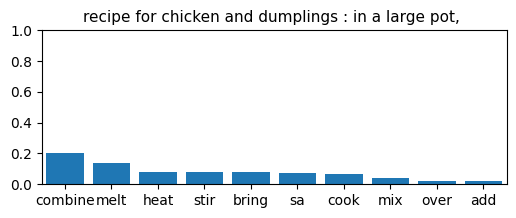

In [14]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=1.0)

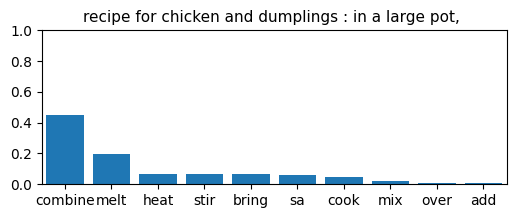

In [15]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.5)

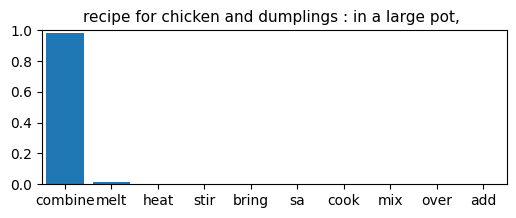

In [16]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.1)